# Comparison of the effectiveness of ensemble regression and simple regression models for air pollution data
## Data inputation

Data source: https://www.kaggle.com/datasets/fedesoriano/air-quality-data-set

*Authors:*
- *Mateusz Smigielski*
- *Jakub Kudryk*


In [86]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statistics import mean 
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge 
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor, RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.neighbors import KNeighborsRegressor

Scenario
1. Choose one column to predict with missing values
2. Delete values -200 from the rest columns - learning set
3. Delete randomly 10% of values from the learning set
4. Do data imputation, recreate missing data using different methods and compare
5. Choose the best methods and fill missing values from choosen column

## Read data

In [87]:
df = pd.read_csv("../AirQuality.csv",sep=";", decimal=",",header=0)

In [88]:
df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH', 'Unnamed: 15', 'Unnamed: 16'],
      dtype='object')

In [89]:
df.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,0.0,0.0
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604,NaN,NaN
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670,NaN,NaN
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,NaN,NaN
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300,NaN,NaN
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800,NaN,NaN
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200,NaN,NaN
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000,NaN,NaN


In [90]:
decribe = df.describe(include='all')
with open('describe.txt', '+w') as file:
    file.write(decribe.to_latex())

In [91]:
df = df.drop(["NMHC(GT)", "Unnamed: 15", "Unnamed: 16", "Date", "Time"], axis=1)

In [92]:
df.dropna(inplace=True)

In [93]:
df.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


## Delete -200 values

Text(0.5, 1.0, 'Map of -200 values')

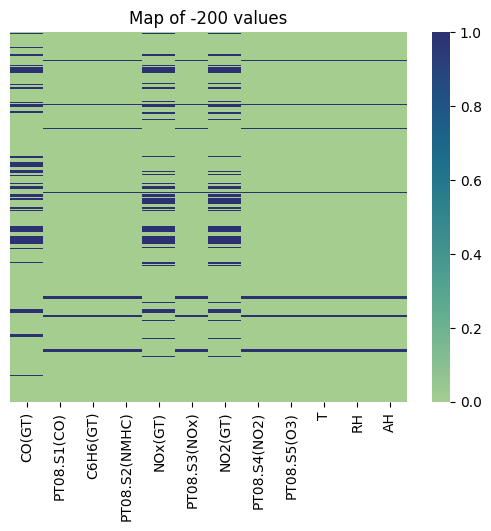

In [94]:
ax = plt.axes()
sns.heatmap(df==-200,yticklabels=False,cmap='crest', ax = ax)
ax.set_title('Map of -200 values')

In [95]:
df.replace(to_replace=-200, value=np.nan, inplace=True)
df.isna().sum()

CO(GT)           1683
PT08.S1(CO)       366
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

In [96]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

In [97]:
missing_value_df

,column_name,percent_missing
CO(GT),CO(GT),17.986534
PT08.S1(CO),PT08.S1(CO),3.911510
C6H6(GT),C6H6(GT),3.911510
PT08.S2(NMHC),PT08.S2(NMHC),3.911510
NOx(GT),NOx(GT),17.516298
PT08.S3(NOx),PT08.S3(NOx),3.911510
NO2(GT),NO2(GT),17.548360
PT08.S4(NO2),PT08.S4(NO2),3.911510
PT08.S5(O3),PT08.S5(O3),3.911510
T,T,3.911510


In [98]:
df.dropna(inplace=True)

## Correlation matrix

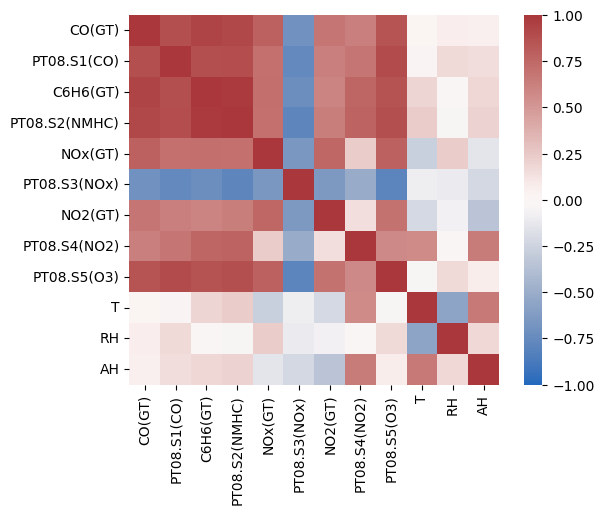

In [99]:
df_corr = df.corr()

axis_corr = sns.heatmap(
df_corr,
vmin=-1, vmax=1, center=0,
cmap="vlag",
square=True
)
plt.show()

## Select attribute with least average correlation

In [100]:
# df_dropped = df.drop(["T", "RH", "AH"], axis=1)
# df_dropped_corr = df_dropped.corr()
# np.fill_diagonal(df_dropped_corr.values, np.nan)
# mean_abs_corr = df_dropped_corr.abs().mean().sort_values()

# least_correlated_attribute = mean_abs_corr.idxmin()
# least_correlated_attribute

## Delete random 10% data in the dataset

In [101]:
to_fill = df["CO(GT)"]
df = df.drop(["CO(GT)"],axis=1)
df_random = df.copy()

In [102]:
for col in df_random.columns:
    df_random.loc[df.sample(frac=0.1).index, col] = np.nan

Text(0.5, 1.0, 'Map of random deleted values')

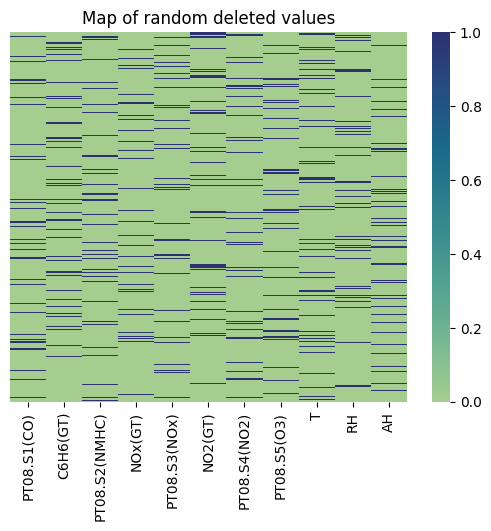

In [103]:
ax = plt.axes()
sns.heatmap(df_random.isna(),yticklabels=False,cmap='crest', ax = ax)
ax.set_title('Map of random deleted values')

## SimpleImpute

In [104]:
mse_table = {
    'SimpleImputer_Mean' : None,
    'SimpleImputer_Median' : None,
    'SimpleImputer_Most_frequent_value' : None,
    'IterativeImputer_BayesianRidge' : None,
    'IterativeImputer_KNeighborsRegressor' : None,
    'IterativeImputer_RandomForest': None
}

### Mean

In [105]:
def calculate_mse(before_df, after_df):
    before_df=(before_df-before_df.mean())/before_df.std()
    after_df=(after_df-after_df.mean())/after_df.std()
    return mean_squared_error(before_df, after_df)

In [106]:
df_mean_impute = df_random.copy()
imp = SimpleImputer(missing_values = np.nan, strategy ='mean')

imp = imp.fit(df_mean_impute)

df_mean_imputed = pd.DataFrame(imp.fit_transform(df_mean_impute))
df_mean_imputed.columns = df_mean_impute.columns
df_mean_imputed.index = df_mean_impute.index

In [107]:
mse_table['SimpleImputer_Mean'] = calculate_mse(df, df_mean_imputed)

### Median

In [108]:
df_median_impute = df_random.copy()
imp = SimpleImputer(missing_values = np.nan, strategy ='median')

imp = imp.fit(df_median_impute)

df_median_imputed = pd.DataFrame(imp.fit_transform(df_median_impute))
df_median_imputed.columns = df_median_impute.columns
df_median_imputed.index = df_median_impute.index

In [109]:
mse_table['SimpleImputer_Median'] = calculate_mse(df, df_median_imputed)

### Most frequent value

In [110]:
df_mf_impute = df_random.copy()
imp = SimpleImputer(missing_values = np.nan, strategy ='most_frequent')

imp = imp.fit(df_mf_impute)

df_mf_imputed = pd.DataFrame(imp.fit_transform(df_mf_impute))
df_mf_imputed.columns = df_mf_impute.columns
df_mf_imputed.index = df_mf_impute.index

In [111]:
mse_table['SimpleImputer_Most_frequent_value'] = calculate_mse(df, df_mf_imputed)

## IterativeImputer

### BayesianRidge estimator

Since the best results were achieved by filling in values using the mean, only this approach will be used in the IterativeImputer.

In [112]:
df_mean_iter = df_random.copy()
imp = IterativeImputer(missing_values = np.nan, initial_strategy='mean', random_state= 42, estimator= BayesianRidge())

imp = imp.fit(df_mean_iter)

df_mean_iter_2 = pd.DataFrame(imp.fit_transform(df_mean_iter))
df_mean_iter_2.columns = df_mean_iter.columns
df_mean_iter_2.index = df_mean_iter.index

/Users/jakubkudryk/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/jakubkudryk/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [113]:
mse_table['IterativeImputer_BayesianRidge' ] = calculate_mse(df, df_mean_iter_2)

### RandomForestRegressor

In [114]:
df_mean_iter_rf = df_random.copy()
imp = IterativeImputer(missing_values = np.nan, initial_strategy='mean', random_state= 42, estimator= RandomForestRegressor())

imp = imp.fit(df_mean_iter_rf)

df_mean_iter_rf_2 = pd.DataFrame(imp.fit_transform(df_mean_iter_rf))
df_mean_iter_rf_2.columns = df_mean_iter_rf.columns
df_mean_iter_rf_2.index = df_mean_iter_rf.index

/Users/jakubkudryk/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/jakubkudryk/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [115]:
df_mean_iter_rf_2.isna()

,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
9352,False,False,False,False,False,False,False,False,False,False,False
9353,False,False,False,False,False,False,False,False,False,False,False
9354,False,False,False,False,False,False,False,False,False,False,False
9355,False,False,False,False,False,False,False,False,False,False,False


In [116]:
mse_table['IterativeImputer_RandomForest'] = calculate_mse(df, df_mean_iter_rf_2)

### KNeighborsRegressor

In [117]:
df_mean_iter_knn = df_random.copy()
imp = IterativeImputer(missing_values = np.nan, initial_strategy='mean', random_state= 42, estimator= KNeighborsRegressor())

imp = imp.fit(df_mean_iter_knn)

df_mean_iter_knn_2 = pd.DataFrame(imp.fit_transform(df_mean_iter_knn))
df_mean_iter_knn_2.columns = df_mean_iter_knn.columns
df_mean_iter_knn_2.index = df_mean_iter_knn.index

/Users/jakubkudryk/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/jakubkudryk/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [118]:
mse_table['IterativeImputer_KNeighborsRegressor'] = calculate_mse(df, df_mean_iter_knn_2)

## Results

In [119]:
mse_table

{'SimpleImputer_Mean': 0.10288690774183662,
 'SimpleImputer_Median': 0.10462326880167773,
 'SimpleImputer_Most_frequent_value': 0.13878252388311482,
 'IterativeImputer_BayesianRidge': 0.012558460670371623,
 'IterativeImputer_KNeighborsRegressor': 0.014795094755278116,
 'IterativeImputer_RandomForest': 0.0061846975419012525}

In [120]:
inputter, result = min(mse_table.items(), key=lambda x: x[1]) 
print(f"Best inputter: {inputter}, result: {result}")

Best inputter: IterativeImputer_RandomForest, result: 0.0061846975419012525


### Read data set again, drop NaN values, replace -200 with Nan and drop rows that contains Nans excluding CO(GT) column

In [121]:
df_co = pd.read_csv("../AirQuality.csv",sep=";", decimal=",",header=0)
df_co = df_co.drop(["NMHC(GT)", "Unnamed: 15", "Unnamed: 16", "Date", "Time"], axis=1)
df_co.dropna(inplace=True)
df_co.replace(to_replace=-200, value=np.nan, inplace=True)
df_co.dropna(subset=['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 
                  'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
                  'PT08.S5(O3)', 'T', 'RH', 'AH'], inplace=True)
df_co.isna().sum()

CO(GT)           452
PT08.S1(CO)        0
C6H6(GT)           0
PT08.S2(NMHC)      0
NOx(GT)            0
PT08.S3(NOx)       0
NO2(GT)            0
PT08.S4(NO2)       0
PT08.S5(O3)        0
T                  0
RH                 0
AH                 0
dtype: int64

In [122]:
imp = IterativeImputer(missing_values = np.nan, initial_strategy='mean', random_state= 42, estimator= RandomForestRegressor())

imp = imp.fit(df_co)

df_co_imputted = pd.DataFrame(imp.fit_transform(df_co))
df_co_imputted.columns = df_co.columns
df_co_imputted.index = df_co.index

In [123]:
df_co_imputted.isna().sum()

CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

In [124]:
described = df_co_imputted.describe()
with open('described.txt', '+w') as file:
    file.write(described.to_latex())

## Simple regression models

In [125]:
msetable = {
    "LinearRegression"             : None,
    "DecisionTreeRegressor_depth1" : None,
    "DecisionTreeRegressor_depth2" : None,
    "DecisionTreeRegressor_depth3" : None,
    "DecisionTreeRegressor_depth4" : None,
    "DecisionTreeRegressor_depth5" : None,
    "DecisionTreeRegressor_depth6" : None,
    "DecisionTreeRegressor_depth7" : None,
    "DecisionTreeRegressor_depth8" : None,
    "DecisionTreeRegressor_depth9" : None,
    "DecisionTreeRegressor_depth10": None,
    "BaggingRegressor"             : None,
    "GradientBoostingRegressor"    : None
    }

In [126]:
def kFold_train_test_model(model, X, y, n_splits=10, random_state=42):
    mse_list=[]
    cv = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        mse_fold = mean_squared_error(y_test, y_predict)
        mse_list.append(mse_fold)
    return mse_list

In [127]:
attributes = ['PT08.S3(NOx)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'AH']
label = 'PT08.S4(NO2)'
models = msetable.keys()

### Linear regression

In [128]:
features = list(set(attributes) - set(label))
X = np.array(df_co_imputted[features])
y = np.array(df_co_imputted[label]).reshape(-1, 1)

lrmodel = LinearRegression()
msetable["LinearRegression"] = kFold_train_test_model(lrmodel, X, y)

### Decision tree regressor

In [129]:
features = list(set(attributes) - set(label))
X = np.array(df_co_imputted[features])
y = np.array(df_co_imputted[label]).reshape(-1, 1)
for maxdepth in range(1,11):
    dcregressor = DecisionTreeRegressor(max_depth=maxdepth)  
    msetable[f"DecisionTreeRegressor_depth{maxdepth}"] = kFold_train_test_model(dcregressor, X, y)

## Ensemble regression

### Gradient Boosting Regressor

In [145]:
features = list(set(attributes) - set(label))
X = np.array(df_co_imputted[features])
y = np.array(df_co_imputted[label]).reshape(-1, 1).ravel()

gbrmodel = GradientBoostingRegressor()
msetable["GradientBoostingRegressor"] = kFold_train_test_model(gbrmodel, X, y)

### Bagging Regressor

In [146]:
features = list(set(attributes) - set(label))
X = np.array(df_co_imputted[features])
y = np.array(df_co_imputted[label]).reshape(-1, 1).ravel()

brmodel = BaggingRegressor()
msetable["BaggingRegressor"] = kFold_train_test_model(brmodel, X, y)

## Comparative analysis

### Mean squared error histograms

In [147]:
def plot_histograms_for_all_models():
    ncols = 4
    keys = models
    nrows = (len(keys) + ncols - 1)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(35, 120))
    axes = axes.flatten()
    
    for i, (key, value) in enumerate(msetable.items()):
        ax = axes[i]
        ax.hist(value, bins=10)
        ax.set_title(key)
        ax.set_xlabel("MSE values")
        ax.set_ylabel("MSE value instances per bin")
    
    for j in range(len(keys), len(axes)):
        fig.delaxes(axes[j])
    plt.show()

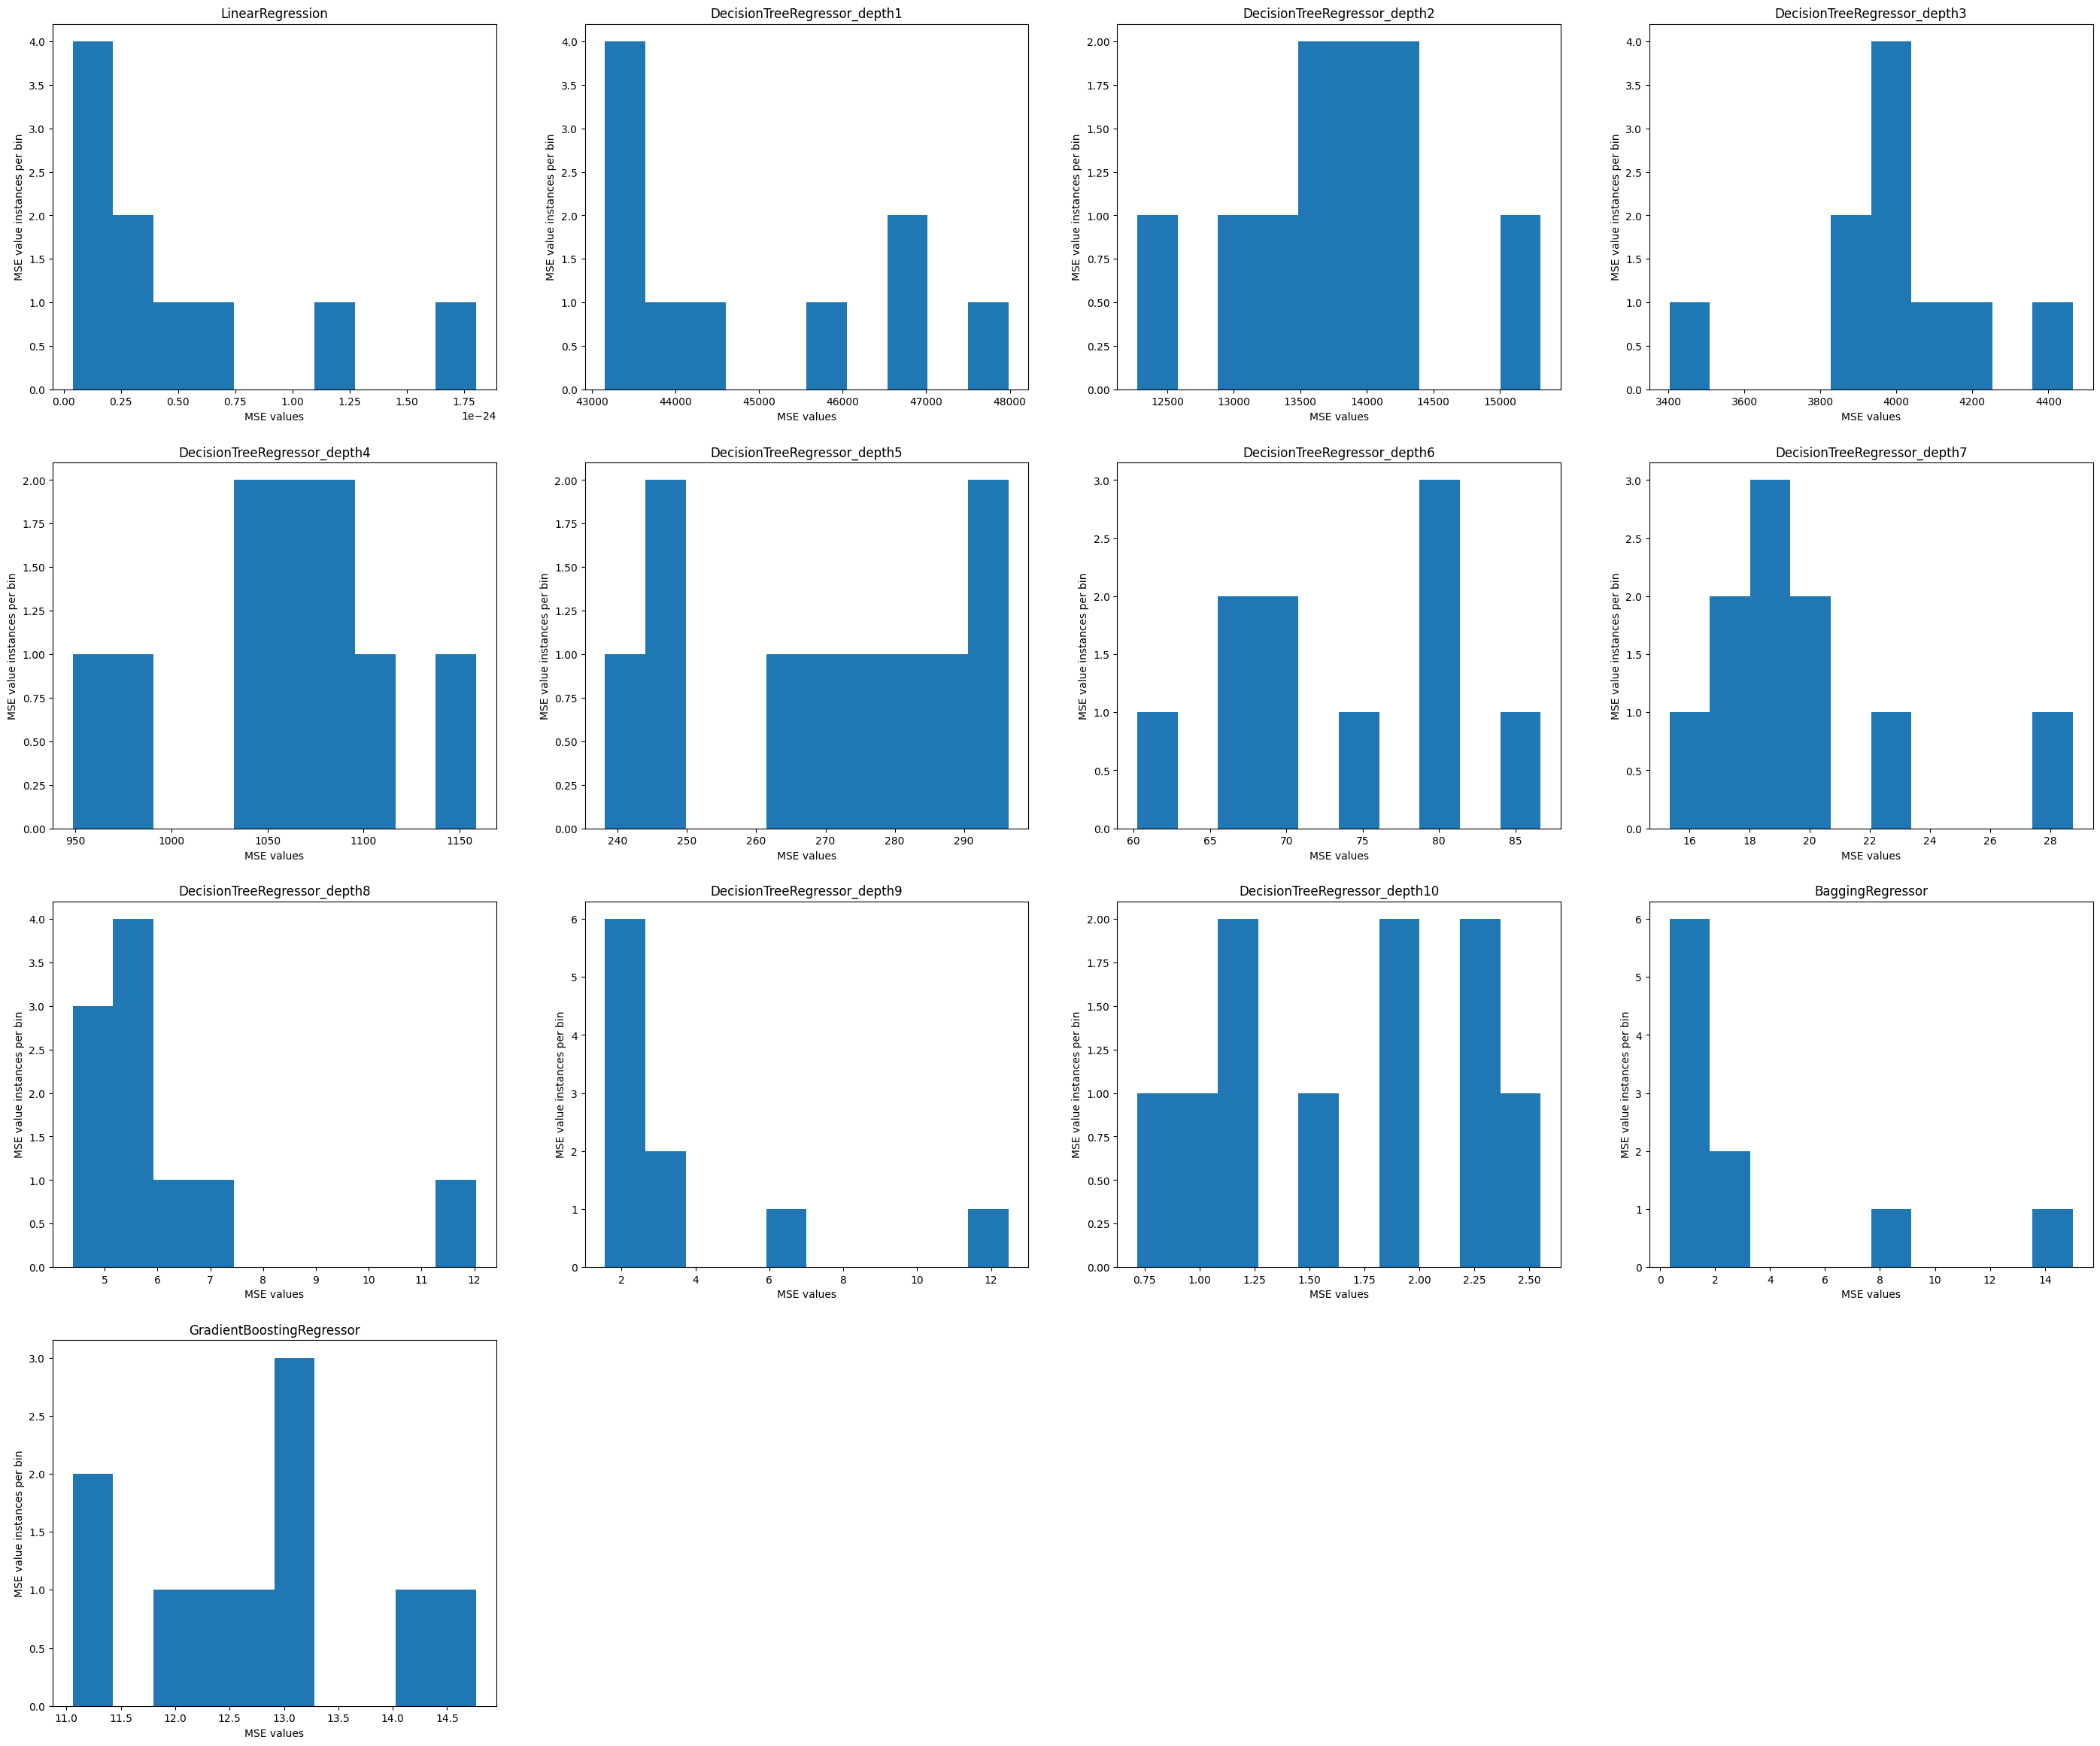

In [148]:
plot_histograms_for_all_models()


Although histograms can show that data normality assumption has not been met, the data sample is too small to claim that, so we use K-Fold CV Paired t Test to compare models.

### K-Fold CV Paired t Test

In [149]:
def create_models_comparison_matrix(p_msetable):
    comparison_matrix = [[-1 for _ in range(len(p_msetable))] for _ in range(len(p_msetable))]
    statistical_significance = 0.05
    
    for i, model1 in enumerate(p_msetable):
        for j, model2 in enumerate(p_msetable):
            pvalue = stats.ttest_rel(p_msetable[model1], p_msetable[model2]).pvalue
            mean1 = mean(p_msetable[model1])
            mean2 = mean(p_msetable[model2])
            is_statistically_significant = pvalue < 0.05
    
            if is_statistically_significant:
                comparison_matrix[i][j] = 0 if mean1 < mean2 else 1
    
    return comparison_matrix

In [150]:
from matplotlib.colors import LinearSegmentedColormap
def plot_models_comparison_matrix(comparison_matrix):
    models_labels = models
    
    
    myColors = ((1.0, 1.0, 1.0, 1.0), (0.0, 0.8, 0.0, 1.0), (0.8, 0.0, 0.0, 1.0))
    cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
    
    comparison_map = sns.heatmap(
    comparison_matrix,
    xticklabels=models_labels, 
    yticklabels=models_labels,
    cmap=cmap,
    linewidths=1, 
    linecolor='black',
    square=True
    )
    
    colorbar = comparison_map.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    colorbar.set_ticklabels(['No statistical difference', 'Y better than X', 'X better than Y'])
    
    comparison_map.set_ylabel('Y')
    comparison_map.set_xlabel('X')
    
    plt.title('Models comparison matrix')
    plt.show()

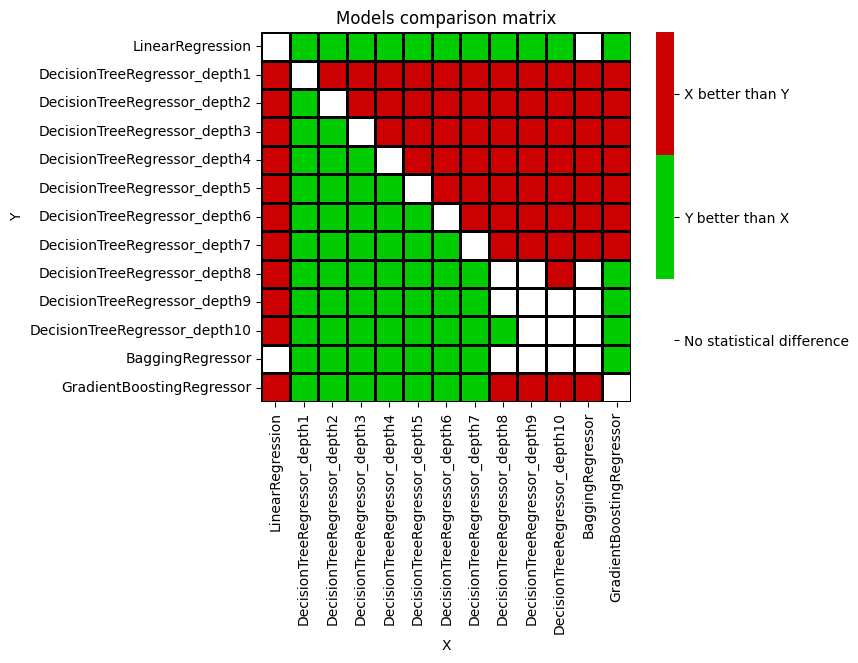

In [151]:
plot_models_comparison_matrix(create_models_comparison_matrix(msetable))